<a href="https://colab.research.google.com/github/Nadian-Ali/Temporary_Vid_classification/blob/main/prepare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>About </h1>
In this notebook, the following are processed:

train and validation data_frames are loaded

1.   Path to each video was added a df column
2.   Using the dataframe frames are loaded
3.   For each video features are extracted (it wasnt neccasssay but a maximum of 500 frames per video was considered)

4. For feature axtraction DenseNet121 was used

5. Results where save based into train and val numpy arrays (in case of much larges dataset HD5 or maybe using arrow lib would have been better) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
root =  '/content/drive/My Drive/Projects/Video_Rec/'
%cd   '/content/drive/My Drive/Projects/Video_Rec/'

/content/drive/My Drive/Projects/Video_Rec


In [ ]:
import cv2
import os
import pandas as pd 
import numpy as np
from google.colab.patches import cv2_imshow

from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import imageio



In [ ]:
data_set      = 'Dataset'

train         = 'train'
val           = 'val'
train_ann     = 'train_action_classes.csv'
val_ann       = 'val_action_classes.csv'
videos_pth    = os.path.join(root,data_set,videos)
train_df_path = os.path.join(root,data_set,train_ann)
val_df_path   = os.path.join(root,data_set,val_ann)
path_to_train = '/content/drive/My Drive/Projects/Video_Rec/Dataset/train'
path_to_val   = '/content/drive/My Drive/Projects/Video_Rec/Dataset/val'


/content/drive/My Drive/Projects/Video_Rec/Dataset/val


<h3> Read data frames and add the vid path col </h3> 

In [ ]:
train_df = pd.read_csv(train_df_path)
val_df =  pd.read_csv(val_df_path)
train_df['vid_path'] = path_to_train + '/' + train_df['participant_id'] + '/' + train_df['video_id'] 
val_df['vid_path']   = path_to_val + '/' + val_df['participant_id'] + '/' + val_df['video_id'] 

In [ ]:
train_df.head(1)

,uid,participant_id,video_id,narration,start_timestamp,stop_timestamp,start_frame,stop_frame,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes,action_class,vid_path
0,1,P01,P01_05,take bread bag,00:08:30.46,00:08:31.35,30627,30681,take,0,bag,20,['bag'],[20],take bag,/content/drive/My Drive/Projects/Video_Rec/Dat...


<p> checking video length </p>

In [ ]:
frames = train_df['stop_frame']-train_df['start_frame']
# print(frames)
frames = val_df['stop_frame']-val_df['start_frame']
# print(frames)


In [ ]:
#@title Duration
time = val_df['start_timestamp'].tolist()
time1 = val_df['stop_timestamp'].tolist()

print(time)
print(time1)


In [ ]:
#@title Check durations
from datetime import datetime
s1 = '00:12.26'
s2 = '00:15.49' # for example
FMT = '%H:%M.%S'
tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
print(tdelta)

<h3> set parameters </h3>

In [ ]:
MAX_SEQ_LENGTH = 500
NUM_FEATURES = 1024
IMG_SIZE = 128


In [ ]:
# NO used 
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped



In [ ]:
type(str(1).zfill(10))

str

In [ ]:
#@title Loading a video

def load_vid(idx,df,path,IMG_SIZE):
    
  start_frame = df['start_frame'][idx]
  stop_frame = df['stop_frame'][idx]
  num_frames = stop_frame - start_frame
  IMSIZE = 128
  frames = []
  for frame_idx in range(start_frame,stop_frame):

    path_to_vid = os.path.join(path,df['participant_id'][idx],df['video_id'][idx],'frame_{}.jpg'.format(str(frame_idx).zfill(10)))
    # print(path_to_vid)
    im = cv2.imread(path_to_vid)
    # print(type(im))
    im = cv2.resize(im,(IMG_SIZE,IMG_SIZE))
    # im = crop_center(im)
    frames.append(im)    
    if frame_idx ==start_frame:
      cv2_imshow(im)
  print('loading video {} finished '.format(idx))
  return frames

# frames = load_vid(idx=3,df=train_df,path=path_to_train,IMG_SIZE=IMG_SIZE)
# print('start frame = {}'.format(start_frame))
# print('stop frame = {}'.format(stop_frame))
# print('total frames = {}'.format(stop_frame-start_frame))
# print('length of frames = {}'.format(len(frames)))

# frames = np.asarray(frames)
# np.shape(frames)




In [ ]:
#extract features from a frame
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()


In [ ]:
def prepare_all_videos(df,path ,IMG_SIZE=IMG_SIZE):
    # path = path_to_train
    # train_df = train_df

    num_samples = len(df)
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    for idx,path_vid in enumerate(df['vid_path']):
      print(path)
      frames = load_vid(idx=idx,df=df,path=path,IMG_SIZE=IMG_SIZE)
      frames = np.array(frames)
      frames = frames[None, ...]
      temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
      temp_frame_features = np.zeros(
          shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
      )

      # Extract features from the frames of the current video.
      for i, batch in enumerate(frames):
          video_length = batch.shape[0]
          length = min(MAX_SEQ_LENGTH, video_length)
          for j in range(length):
              temp_frame_features[i, j, :] = feature_extractor.predict(
                  batch[None, j, :]
              )
          temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

      frame_features[idx,] = temp_frame_features.squeeze()
      frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks)#, labels

   

<h1> Extract features and save them </h1?

/content/drive/My Drive/Projects/Video_Rec/Dataset/train


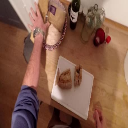

loading video 0 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


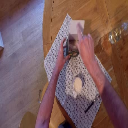

loading video 1 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


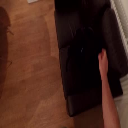

loading video 2 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


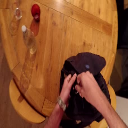

loading video 3 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


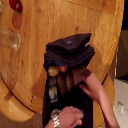

loading video 4 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


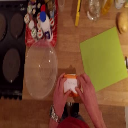

loading video 5 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


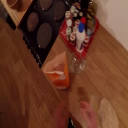

loading video 6 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


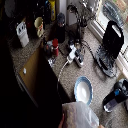

loading video 7 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


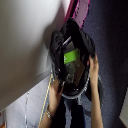

loading video 8 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


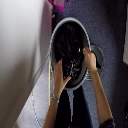

loading video 9 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


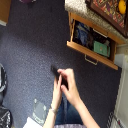

loading video 10 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


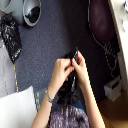

loading video 11 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/train


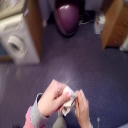

loading video 12 finished 


In [ ]:
train_data = prepare_all_videos(df=train_df,path = path_to_train,IMG_SIZE=IMG_SIZE)
np.save('train_data.npy',train_data[0])
np.save('train_mask.npy',train_data[1])



In [ ]:
#check features 

for _ in range(10):
  print(train_data[0][_,1,:10])

[3.3596694e-04 7.1080662e-03 6.6049923e-03 3.7933169e-03 1.8645003e-01
 9.4040000e-01 1.0193748e-03 4.6936697e-03 7.6439351e-02 9.7843329e-04]
[8.8539545e-04 6.2077502e-03 5.1017790e-03 4.2590685e-03 1.6853251e-01
 1.5385206e+00 7.1289361e-04 5.6796353e-03 3.1787694e-01 1.0079503e-03]
[4.9965619e-04 4.4226563e-03 4.2461781e-03 3.2495798e-03 1.2495342e-01
 2.5777018e-01 1.2904822e-04 3.3068629e-03 4.7777165e-02 6.9151400e-04]
[2.28535078e-04 1.14380773e-02 4.71467618e-03 5.74782211e-03
 2.18983024e-01 5.84593594e-01 8.26538308e-04 7.44260801e-03
 1.23806775e-01 6.66478532e-04]
[4.7662412e-04 9.6244942e-03 3.5420596e-03 2.9590013e-03 2.1817493e-01
 9.3208152e-01 5.5455137e-04 4.0383665e-03 6.7868508e-02 6.1581132e-04]
[6.4921111e-04 1.2522128e-02 6.1631473e-03 3.8240263e-03 1.5320921e-01
 8.4832734e-01 8.2870404e-04 4.5852619e-03 6.0283419e-02 2.7718913e-04]
[7.04474689e-04 7.36754201e-03 5.01866732e-03 4.13210597e-03
 6.52215332e-02 1.05308855e+00 4.71602310e-04 6.17730524e-03
 1.156884

/content/drive/My Drive/Projects/Video_Rec/Dataset/val


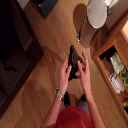

loading video 0 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/val


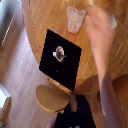

loading video 1 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/val


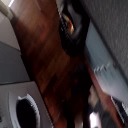

loading video 2 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/val


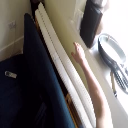

loading video 3 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/val


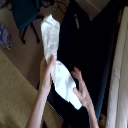

loading video 4 finished 
/content/drive/My Drive/Projects/Video_Rec/Dataset/val


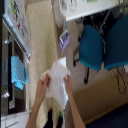

loading video 5 finished 


In [ ]:

val_data = prepare_all_videos(df=val_df,path=path_to_val,IMG_SIZE=IMG_SIZE)
np.save('val_data.npy',val_data[0])
np.save('val_mask.npy',val_data[1])


In [ ]:

for _ in range(2):
  print(val_data[0][_,1,:10])

[2.0392792e-04 7.8657996e-03 3.7158183e-03 2.7061985e-03 2.1784985e-01
 7.4037457e-01 6.5267866e-04 3.7965183e-03 3.0412378e-02 5.7968131e-04]
[4.2517253e-04 7.5573586e-03 9.1624670e-03 5.2028028e-03 8.1987418e-02
 7.7273029e-01 5.4005126e-04 5.8019091e-03 1.5695718e-01 5.2166032e-04]


In [ ]:
val_data = prepare_all_videos(df=val_df,path=path_to_val,IMG_SIZE=IMG_SIZE)
np.save('val_data.npy',val_data[0])
np.save('val_mask.npy',val_data[1])
